In [1]:
import os
import sys
sys.path.append('../')

from IPython.core.pylabtools import figsize

#from utils import get_intervals
from utils import get_scanpy_lfcs, get_seurat_lfcs, get_ZILN_lfcs, transform, compute_p_vals

In [2]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from sklearn.metrics import confusion_matrix
import scanpy as sc

/home/oskar/anaconda3/envs/pythonProject/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/oskar/anaconda3/envs/pythonProject/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/oskar/anaconda3/envs/pythonProject/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/oskar/anaconda3/envs/pythonProject/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/oskar/anaconda3/envs/pythonProject/lib/python3.10/site-packages/anndata/util

In [3]:
def log_transform(x, scale_factor=10000):
    norm_x = np.log(scale_factor * x/x.sum(0))
    return(norm_x)

# x numpy vector of counts
# transformation to apply to the non-zero elements of x.
def process_counts(x, transformation):
    cell_count = len(x)
    N_0 = np.sum(x == 0)
    N_plus = cell_count - N_0
    t_x = transformation(x[np.where(x > 0)])    
    return(t_x, N_plus, N_0)

# return p-value -- we are using Normal assumption on the means for inference. The null is that the means are the same.
def infer_lfc(m_x, s_x, m_y, s_y):
    diff = m_x - m_y 
    s_hat = np.sqrt((s_x**2) + (s_y**2))
    lb = diff - 1.96*s_hat
    ub = diff + 1.96*s_hat
    # Compute the p-value.
    z_score = diff / s_hat
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    return(lb,ub,p_value)


In [4]:
# Read in the counts data
data_folder = "../simul/splatter/"
X = pd.read_csv(os.path.join(data_folder, "X.csv")).to_numpy()
Y = pd.read_csv(os.path.join(data_folder, "Y.csv")).to_numpy()
#cell_counts_X = X.sum(axis=1)
#cell_counts_Y = Y.sum(axis=1)
n_genes = Y.shape[0]
n_cells = Y.shape[1]
print("n_genes: ", n_genes)
print("n_cells: ", n_cells)
print("shape X:", X.shape)
print("shape Y:", Y.shape)

lfcs = pd.read_csv(os.path.join(data_folder, "fc.csv"))
lfcs2 = pd.read_csv(os.path.join(data_folder, "fc2.csv"))
#idx = np.argsort(lfcs)

# Y_A = Y[:,X.loc[X["trt"] == "A"].index]
# Y_B = Y[:,X.loc[X["trt"] == "B"].index]
# print(Y_A.shape)
# print(Y_B.shape)


n_genes:  4043
n_cells:  973
shape X: (4043, 1027)
shape Y: (4043, 973)


In [5]:
X = X.transpose()
Y = Y.transpose()

print("shape Y:", Y.shape)

shape Y: (973, 4043)


In [6]:
ziln_lfcs, p_vals = get_ZILN_lfcs(np.exp(transform(Y)) - 1, np.exp(transform(X)) - 1, eps=1e-30, return_p_vals=True)

In [7]:
adj_pvals = smm.multipletests(p_vals, alpha=0.05, method='fdr_bh')[1]
adj_pvals

array([9.58760995e-01, 9.22421969e-01, 9.69584029e-01, ...,
       9.98264157e-01, 9.87717989e-01, 1.28117762e-06])

In [8]:
pred_sig_idx = (adj_pvals < 0.05)

In [9]:
gt_sig_idx = (lfcs["true_log2_fc"] != 0)

In [10]:
conf_mat = confusion_matrix(gt_sig_idx, pred_sig_idx)
conf_mat

array([[3237,   23],
       [ 333,  450]])

In [11]:
tn, fp, fn, tp = conf_mat.ravel()

In [12]:
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# Print results
print(f"TPR: {tpr:.2f}")
print(f"TNR: {tnr:.2f}")
print(f"FPR: {fpr:.2f}")
print(f"FNR: {fnr:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

TPR: 0.57
TNR: 0.99
FPR: 0.01
FNR: 0.43
Precision: 0.95
Recall: 0.57


In [13]:
gt_lfcs = lfcs["true_log2_fc"]
print("Ground Truth:")
print("#LFCs: ", gt_sig_idx.sum())
print("#Non-LFCs: ", (1 - gt_sig_idx).sum())

print("ZILN:")
print("#LFCs: ", pred_sig_idx.sum())
print("#Non-LFCs: ", (1 - pred_sig_idx).sum())

Ground Truth:
#LFCs:  783
#Non-LFCs:  3260
ZILN:
#LFCs:  473
#Non-LFCs:  3570


In [14]:
import diffxpy.api as de

In [15]:
def evaluate_diffxpy(X, Y, gt_lfc, alpha=0.05, method="wald"):
    """
    Evaluates differential expression using diffxpy and computes TP, FP, TN, FN.

    Parameters:
    - X (numpy.ndarray): Control data (n_cells x n_genes).
    - Y (numpy.ndarray): Treatment data (n_cells x n_genes).
    - gt_lfc (numpy.ndarray): Ground truth log-fold changes (n_genes,).
    - alpha (float): Significance level for adjusted p-values (default: 0.05).
    - method (str): Method for differential expression (e.g., 'wald', 'lrt').

    Returns:
    - results (dict): A dictionary containing TP, FP, TN, FN counts.
    """
    # X = np.log(X + 1)
    # Y = np.log(Y + 1)
    
    adata_X = sc.AnnData(X)
    adata_Y = sc.AnnData(Y)

    # Add condition labels
    adata_X.obs['condition'] = 'control'
    adata_Y.obs['condition'] = 'treatment'

    # Concatenate control and treatment into one AnnData object
    adata = adata_X.concatenate(adata_Y)

    # Perform differential expression analysis
    # test = de.test.wald(adata, factor_loc_totest='condition', test="two-sided" if method == "wald" else method)
    if method == "t-test":
        test = de.test.t_test(adata, grouping='condition', is_logged=False)
    else:
        test = de.test.rank_test(adata, grouping='condition', is_logged=False)
    
    # Extract adjusted p-values and log-fold changes
    pvals_adj = test.qval
    lfc = test.log_fold_change(2)

    # Identify significant genes based on adjusted p-values
    significant_genes = (pvals_adj < alpha).astype(int)  # 1 for significant, 0 otherwise

    # Ground truth significant genes (1 if LFC != 0, 0 otherwise)
    gt_significant = (gt_lfc != 0).astype(int)

    # Compute TP, FP, TN, FN
    TP = np.sum((significant_genes == 1) & (gt_significant == 1))
    FP = np.sum((significant_genes == 1) & (gt_significant == 0))
    TN = np.sum((significant_genes == 0) & (gt_significant == 0))
    FN = np.sum((significant_genes == 0) & (gt_significant == 1))

    return {"TP": TP, "FP": FP, "TN": TN, "FN": FN, 'lfc': lfc}

results = evaluate_diffxpy(Y, X, gt_lfcs, method='t-test', alpha=0.05)

# Print results
print("Evaluation Results:")
print(f"True Positives (TP): {results['TP']}")
print(f"False Positives (FP): {results['FP']}")
print(f"True Negatives (TN): {results['TN']}")
print(f"False Negatives (FN): {results['FN']}")

Evaluation Results:
True Positives (TP): 459
False Positives (FP): 9
True Negatives (TN): 3251
False Negatives (FN): 324


/tmp/ipykernel_159199/4057338958.py:26: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_X.concatenate(adata_Y)


In [16]:
tp, fp, tn, fn = results['TP'], results['FP'], results['TN'], results['FN']

tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# Print results
print(f"TPR: {tpr:.2f}")
print(f"TNR: {tnr:.2f}")
print(f"FPR: {fpr:.2f}")
print(f"FNR: {fnr:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

TPR: 0.59
TNR: 1.00
FPR: 0.00
FNR: 0.41
Precision: 0.98
Recall: 0.59


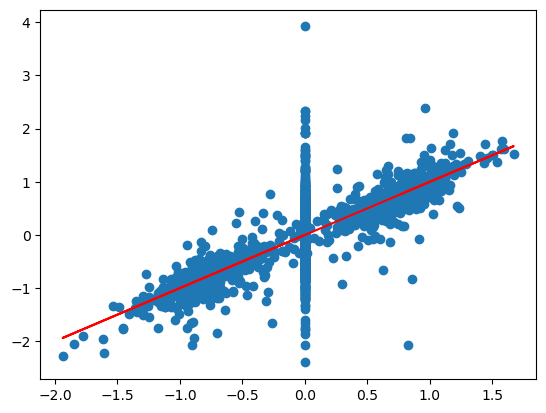

0.11322779398700213
0.1584292221259064


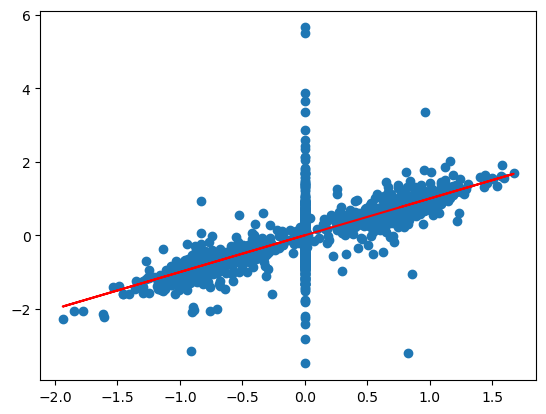

In [17]:
idx = np.abs(results['lfc']) < 100. 
plt.scatter(gt_lfcs[idx], results['lfc'][idx])
plt.plot(gt_lfcs, gt_lfcs, color='red')
plt.show()
print(np.mean((gt_lfcs[idx] - results['lfc'][idx]) ** 2))
plt.scatter(gt_lfcs[idx], ziln_lfcs[idx])
plt.plot(gt_lfcs, gt_lfcs, color='red')
print(np.mean((gt_lfcs[idx] - ziln_lfcs[idx]) ** 2))
plt.show()

In [18]:
idx = np.abs(results['lfc']) < 100. 
print(np.mean(X[:, idx], 0))
print(np.mean(X[:, ~idx], 0))

[0.21908471 0.0895813  0.37000974 ... 0.06037001 0.24342746 0.28432327]
[0.         0.00292113 0.00194742 0.00292113 0.00389484 0.
 0.         0.         0.        ]


#FNs:  333


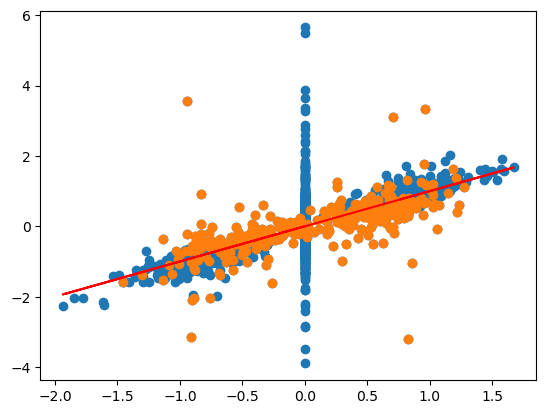

In [19]:
# indices of all false negatives
FN_idx = ((gt_sig_idx.astype(int) - pred_sig_idx.astype(int)) > 0).astype(bool)
# print(np.arange(len(FN_idx))[FN_idx])

print("#FNs: ", FN_idx.sum())
# print(np.sum(X[:, FN_idx], 0))
# print(np.sum(Y[:, FN_idx], 0))
plt.scatter(gt_lfcs, ziln_lfcs)
plt.scatter(gt_lfcs[FN_idx], ziln_lfcs[FN_idx])
plt.plot(gt_lfcs, gt_lfcs, color='red')
plt.show()


In [20]:
# seurat_lfcs = get_seurat_lfcs(Y.transpose(), X.transpose(), normalize=True)
seurat_lfcs = get_seurat_lfcs(Y, X, normalize=True)
scanpy_lfcs = get_scanpy_lfcs(Y, X, normalize=True)
#seurat_lfcs = get_seurat_lfcs(Y, X, normalize=True)

In [21]:
ii = (ziln_lfcs == np.inf) | (ziln_lfcs == -np.inf)
jj = np.isnan(lfcs2["avg_log2FC"])
print(np.where(ii))
kk = ii | jj

(array([], dtype=int64),)


In [22]:
np.mean((ziln_lfcs[~kk] - gt_lfcs[~kk])**2)

np.float64(0.1814894050864767)

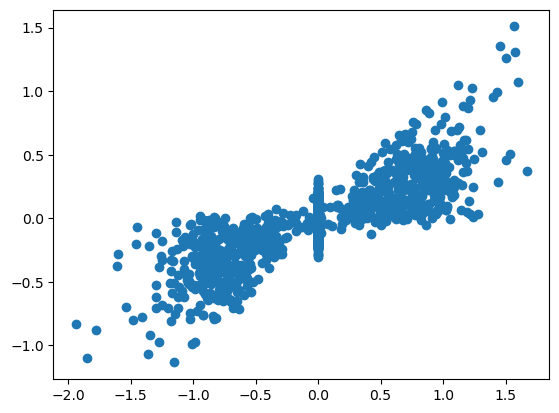

In [23]:
plt.scatter(gt_lfcs, seurat_lfcs)

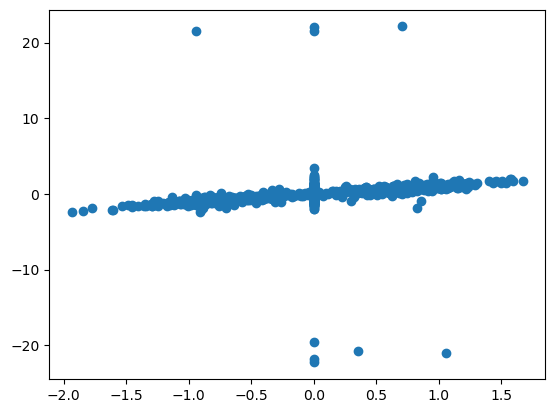

In [24]:
plt.scatter(gt_lfcs, scanpy_lfcs)

/tmp/ipykernel_159199/442298140.py:3: RuntimeWarning: divide by zero encountered in divide
  unb_lfcs = np.log2(unb_x_est/unb_y_est)
/tmp/ipykernel_159199/442298140.py:3: RuntimeWarning: invalid value encountered in divide
  unb_lfcs = np.log2(unb_x_est/unb_y_est)
/tmp/ipykernel_159199/442298140.py:3: RuntimeWarning: divide by zero encountered in log2
  unb_lfcs = np.log2(unb_x_est/unb_y_est)


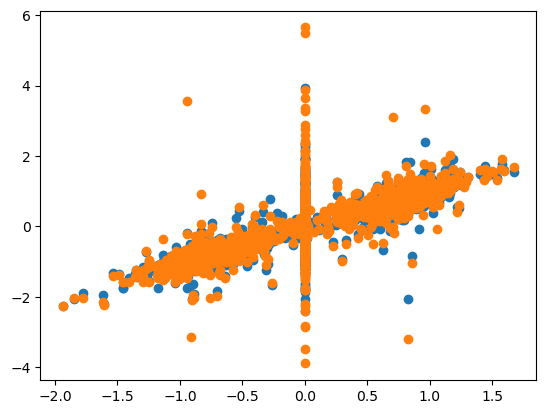

In [25]:
unb_y_est = np.mean(Y, 0)
unb_x_est = np.mean(X, 0)
unb_lfcs = np.log2(unb_x_est/unb_y_est)
plt.scatter(gt_lfcs, unb_lfcs)
plt.scatter(gt_lfcs, ziln_lfcs)
plt.show()

/tmp/ipykernel_159199/3430626136.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(ziln_lfcs, -np.log10(p_vals))


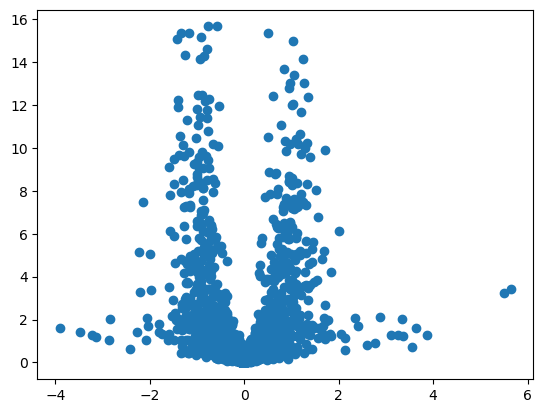

/tmp/ipykernel_159199/3430626136.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(gt_lfcs, -np.log10(p_vals))


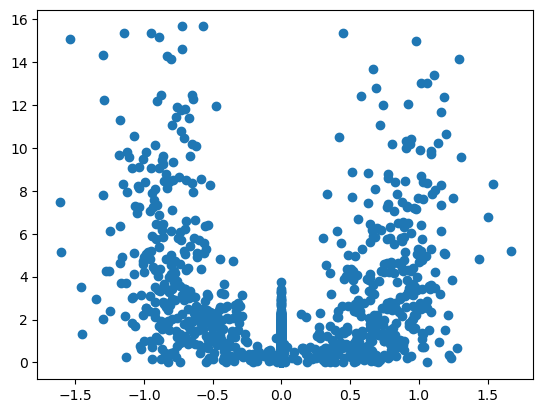

In [26]:
plt.scatter(ziln_lfcs, -np.log10(p_vals))
plt.show()
plt.scatter(gt_lfcs, -np.log10(p_vals))
plt.show()